In [1]:
# install the folium library
!pip install folium
# install the geopy library
!pip install geopy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [9]:
# import libraries
import time
import requests
import json
import os.path
import pandas as pd
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy import distance
import folium
import datetime
import matplotlib.pyplot as plt

In [2]:
# list of cities, first will be used as reference city
cities = ['caldas da rainha', 'viseu', 'coimbra', 'leiria', 'tomar', 'santarém','aveiro','soure','odemira', 'lagoa', 'faro']

geolocator = Nominatim(user_agent='ipt_big_data_rui_shoaib') # create a Nominatim geolocator specifying a user agent
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1) # pass it through a rate limiter to not exceed limits imposed by Nominatim (1 request/s)

cities_df = pd.DataFrame(columns=['city', 'latitude', 'longitude']) # create a dataframe to hold the data

# iterate through each city
for city in cities:
    raw = geocode(city) # geocode with a delay form the ratelimiter
    if raw:
        cities_df = pd.concat([cities_df, pd.DataFrame([{
            'city': city,
            'latitude': raw.latitude,
            'longitude': raw.longitude,
        }])], ignore_index=True) # append to dataframe
    else:
        print(f'Error: failed to geocode {city}')

cities_df # display dataframe

,city,latitude,longitude
0,caldas da rainha,39.407186,-9.134600
1,viseu,40.657471,-7.913866
2,coimbra,40.211193,-8.429463
3,leiria,39.743790,-8.807112
4,tomar,39.603660,-8.415049
5,santarém,39.236364,-8.686708
6,aveiro,40.640496,-8.653784
7,soure,40.059503,-8.626390
8,odemira,37.597600,-8.642200
9,lagoa,37.132581,-8.455051


In [142]:
ref_city = cities_df.iloc[0] # first city as ref

for i, row in cities_df.iterrows():
    ref_coor = (ref_city['latitude'], ref_city['longitude']) # ref city coordinates
    cur_coor = (row['latitude'], row['longitude']) # current city coordinates
    dist = distance.distance(ref_coor, cur_coor).km # calculates distance between ref city & current city in km
    cities_df.at[i, 'ref_city'] = ref_city['city'] # it's a good idea to keep track of ref city individually by adding a col, in case we use multiple ref cities in the future
    cities_df.at[i, 'dist_to_ref_km'] = dist # add a col with the distance

ref_city = cities_df.iloc[0] # update ref city

cities_df.to_json('cities_df.json') # export to json

cities_df # display dataframe

,city,latitude,longitude,ref_city,dist_to_ref_km
0,caldas da rainha,39.407186,-9.134600,caldas da rainha,0.000000
1,viseu,40.657471,-7.913866,caldas da rainha,173.572683
2,coimbra,40.211193,-8.429463,caldas da rainha,107.772091
3,leiria,39.743790,-8.807112,caldas da rainha,46.780356
4,tomar,39.603660,-8.415049,caldas da rainha,65.617884
5,santarém,39.236364,-8.686708,caldas da rainha,43.027837
6,aveiro,40.640496,-8.653784,caldas da rainha,142.958755
7,soure,40.059503,-8.626390,caldas da rainha,84.519590
8,odemira,37.597600,-8.642200,caldas da rainha,205.414604
9,lagoa,37.132581,-8.455051,caldas da rainha,259.390740


In [233]:
map = folium.Map(location=[39.3, -8], zoom_start=7) # create a map object

def getMarkerPopup(row, reference=False):
    return """
<!DOCTYPE html>
<html>
<head>
<style>
table {
  font-family: arial, sans-serif;
  border-collapse: collapse;
  width: 100%;
}

td, th {
  border: 1px solid #dddddd;
  text-align: left;
  padding: 8px;
}

tr:nth-child(even) {
  background-color: #dddddd;
}
</style>
</head>
<body>

<h4>"""+row['city'].title()+"""</h4>
""" + ("<h5>(Reference City)</h5>" if reference else "")+ """

<table>
  <tr>
    <th>Latitude</th>
    <th>Longitude</th>
    <th>Reference City</th>
    <th>Distance to Reference City</th>
  </tr>
  <tr>
    <td>""" + str(row['latitude']) + """</td>
    <td>""" + str(row['longitude']) + """</td>
    <td>""" + row['ref_city'].title() + """</td>
    <td>{:.2f}""".format(row['dist_to_ref_km']) + """ KM</td>
  </tr>
</table>

</body>
</html>
    """

folium.Marker(
    location=(ref_city['latitude'], ref_city['longitude']),
    popup=getMarkerPopup(ref_city, True),
    icon=folium.Icon(color='green')
).add_to(map) # add reference city marker and make it stand out

# iterate over the dataframe, [1:] skips first row bcz it's the ref city
for i, row in cities_df[1:].iterrows():
    folium.Marker(location=[row['latitude'], row['longitude']], popup=getMarkerPopup(row)).add_to(map) # add a marker for each city to the map

map # display the map

In [4]:
openweathermap_api_key = '2c7a57835bdb1afab7ea8699e8b319d4' # openweathermap api keys take ~2 hours to be activated, until then a 401 will be received

filename = 'hourly_weather.json'

# run every hour indefintely until interrupted forcefully
#while True:
    snapshots = []

    # check if file exists, if yes load it as json. This could fail if file conent is not a json array
    if os.path.isfile(filename):
        # read JSON file
        with open(filename) as fp:
            snapshots = json.load(fp)

    for i, row in cities_df.iterrows():
        # https://openweathermap.org/current
        res = requests.get(f'https://api.openweathermap.org/data/2.5/weather?lat={row["latitude"]}&lon={row["longitude"]}&units=metric&appid={openweathermap_api_key}')
        if res.status_code == 200:
            weather = res.json()
            # we are interested in Temperature • Humidity • Pressure • Description • Wind speed • Wind degree • Timestamp (dt)
            snapshot = {
                'city': row['city'],
                'timestamp': weather['dt'],
                'temp_celcius': weather['main']['temp'],
                'humidity': weather['main']['humidity'],
                'pressure_millibar': weather['main']['pressure'],
                'wind_speed_m_per_s': weather['wind']['speed'],
                'wind_dir_deg': weather['wind']['deg'],
                'description': weather['weather'][0]['description'], # first description
            }
            snapshots.append(snapshot)
        else:
            print(f'Error: failed to get weather data for {row["city"]}')

    with open(filename, 'w') as json_file:
        json.dump(snapshots, json_file, indent=4,separators=(',',': '))

    print(f'Appended weather snapshots to {filename}. Next job in 1 hour')

    time.sleep(3600)

IndentationError: unexpected indent (Temp/ipykernel_20604/2230881974.py, line 7)

In [161]:
file_name = "hourly_weather.json"

with open(file_name, "r") as readfile:
    data = json.load(readfile)

#Impressao com recurso ao pretty print
#import pprint
#pprint.pprint(data)

In [162]:
df = pd.DataFrame.from_dict(data, orient='columns')
df

,city,timestamp,temp_celcius,humidity,pressure_millibar,wind_speed_m_per_s,wind_dir_deg,description
0,caldas da rainha,1672244170,15.68,85,1023,2.68,189,overcast clouds
1,viseu,1672243804,13.60,92,1023,3.44,229,overcast clouds
2,coimbra,1672243804,16.97,86,1024,3.11,223,overcast clouds
3,leiria,1672243820,16.03,79,1024,0.45,178,overcast clouds
4,tomar,1672243756,12.88,92,1024,2.28,208,overcast clouds
...,...,...,...,...,...,...,...,...
1821,aveiro,1672733092,7.06,80,1032,2.45,109,scattered clouds
1822,soure,1672733092,5.63,88,1032,1.51,83,scattered clouds
1823,odemira,1672733093,7.83,89,1031,2.02,37,clear sky
1824,lagoa,1672733093,8.15,78,1030,3.85,6,clear sky


In [163]:
df['datetime'] = pd.to_datetime(df['timestamp'], unit='s')
df['Date'], df['Time'] = df['datetime'].dt.normalize(), df['datetime'].dt.time

In [164]:
df.head()

,city,timestamp,temp_celcius,humidity,pressure_millibar,wind_speed_m_per_s,wind_dir_deg,description,datetime,Date,Time
0,caldas da rainha,1672244170,15.68,85,1023,2.68,189,overcast clouds,2022-12-28 16:16:10,2022-12-28,16:16:10
1,viseu,1672243804,13.60,92,1023,3.44,229,overcast clouds,2022-12-28 16:10:04,2022-12-28,16:10:04
2,coimbra,1672243804,16.97,86,1024,3.11,223,overcast clouds,2022-12-28 16:10:04,2022-12-28,16:10:04
3,leiria,1672243820,16.03,79,1024,0.45,178,overcast clouds,2022-12-28 16:10:20,2022-12-28,16:10:20
4,tomar,1672243756,12.88,92,1024,2.28,208,overcast clouds,2022-12-28 16:09:16,2022-12-28,16:09:16


In [165]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1826 entries, 0 to 1825
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   city                1826 non-null   object        
 1   timestamp           1826 non-null   int64         
 2   temp_celcius        1826 non-null   float64       
 3   humidity            1826 non-null   int64         
 4   pressure_millibar   1826 non-null   int64         
 5   wind_speed_m_per_s  1826 non-null   float64       
 6   wind_dir_deg        1826 non-null   int64         
 7   description         1826 non-null   object        
 8   datetime            1826 non-null   datetime64[ns]
 9   Date                1826 non-null   datetime64[ns]
 10  Time                1826 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(4), object(3)
memory usage: 157.0+ KB


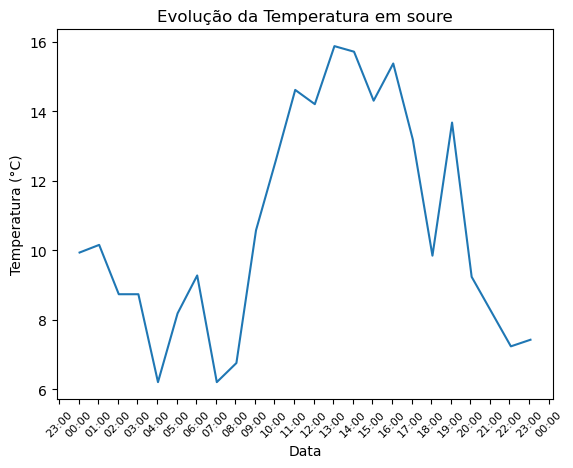

In [201]:
import matplotlib.dates as mdates

city = 'soure'
date = '2023-01-02'

df_city = df[(df['city'] == city) & (df['Date'] == date)]

plt.plot(df_city['datetime'], df_city['temp_celcius'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title(f'Evolução da Temperatura em {cidade}')
plt.xticks(rotation=45, fontsize=8)
plt.show()

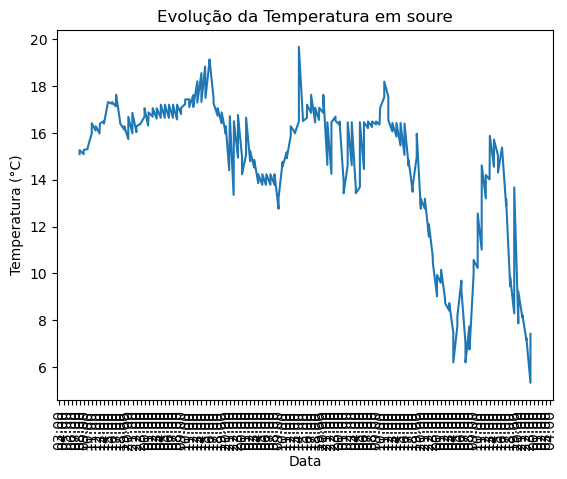

In [229]:
city1 = 'soure'
city2 = 'leiria'
start_date = '2022-12-29'
end_date = '2023-01-02'

df_filtred = df[( (df['city'] == city1) | (df['city'] == city2) ) &  (df['Date'] >= start_date) & (df['Date'] <= end_date)]


plt.plot(df_filtred['datetime'], df_filtred['temp_celcius'])
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
plt.gca().xaxis.set_major_locator(mdates.HourLocator())

plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title(f'Evolução da Temperatura em {cidade}')
plt.xticks(rotation=90)
plt.show()

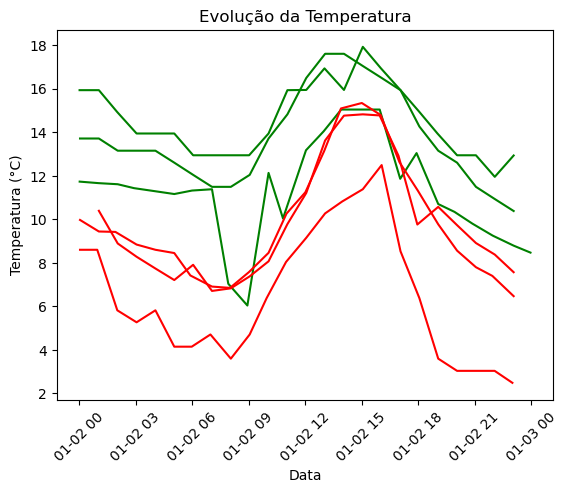

In [236]:
city = 'faro'
city2 = 'aveiro'
city3 = 'lagoa'
city4 = 'viseu'
city5 = 'tomar'
city6 = 'santarém'

start_date = '2023-01-02'
end_date = '2023-01-02'

df_filtred = df[(df['city'] == city) &  (df['Date'] >= start_date) & (df['Date'] <= end_date)]
df_filtred2 = df[(df['city'] == city2) &  (df['Date'] >= start_date) & (df['Date'] <= end_date)]
df_filtred3 = df[(df['city'] == city3) &  (df['Date'] >= start_date) & (df['Date'] <= end_date)]
df_filtred4 = df[(df['city'] == city4) &  (df['Date'] >= start_date) & (df['Date'] <= end_date)]
df_filtred5 = df[(df['city'] == city5) &  (df['Date'] >= start_date) & (df['Date'] <= end_date)]
df_filtred6 = df[(df['city'] == city6) &  (df['Date'] >= start_date) & (df['Date'] <= end_date)]

plt.plot(df_filtred['datetime'], df_filtred['temp_celcius'], color='g')
plt.plot(df_filtred2['datetime'], df_filtred2['temp_celcius'], label=city2, color='g')
plt.plot(df_filtred3['datetime'], df_filtred3['temp_celcius'], label=city3, color='g')
plt.plot(df_filtred4['datetime'], df_filtred4['temp_celcius'], label=city3, color='r')
plt.plot(df_filtred5['datetime'], df_filtred5['temp_celcius'], label=city3, color='r')
plt.plot(df_filtred6['datetime'], df_filtred6['temp_celcius'], label=city3, color='r')
plt.xlabel('Data')
plt.ylabel('Temperatura (°C)')
plt.title(f'Evolução da Temperatura')
plt.xticks(rotation=45)
plt.show()